## Imports

In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
data_directory = '../input/rsnatraintestcombined/RSNA-train'
input_monaipath = "/kaggle/input/monai-v060-deep-learning-in-healthcare-imaging/"
monaipath = "/kaggle/tmp/monai/"

In [3]:
!mkdir -p {monaipath}
!cp -r {input_monaipath}/* {monaipath}

## Configs

In [4]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE = 4
N_EPOCHS = 20
SEED = 2001
LEARNING_RATE = 0.0005
LR_DECAY = 0.9

sys.path.append(monaipath)

from monai.networks.nets.densenet import DenseNet121

## Functions to load images

In [5]:
def load_dicom_image(path, img_size=SIZE):
#     dicom = pydicom.read_file(path)
#     data = dicom.pixel_array
    data = cv2.imread(path, -1)
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    
    data = cv2.resize(data, (img_size, img_size))
    return data


def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    files = natural_sort(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.jpg"))
    
    every_nth = len(files) / num_imgs
    indexes = [min(int(round(i*every_nth)), len(files)-1) for i in range(0,num_imgs)]
    
    files_to_load = [files[i] for i in indexes]
    
    img3d = np.stack([load_dicom_image(f) for f in files_to_load]).T 
    
    img3d = img3d - np.min(img3d)
    if np.max(img3d) != 0:
        img3d = img3d / np.max(img3d)
    
    return np.expand_dims(img3d,0)


load_dicom_images_3d("00000", mri_type=mri_types[0]).shape

(1, 256, 256, 64)

In [6]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

## train / test splits

In [7]:
samples_to_exclude = [109, 123, 709]
target_files = [1,15,47,80,119,129,145,153,174,181,182,190,200,213,252,256,264,287,323,333,335,393,422,428,434,458,460,463,467,489,492,553,573,592,603,647,662,721,762,821,825,826,833,997]
train_df = pd.read_csv(f"../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
print("original shape", train_df.shape)
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
add = pd.DataFrame({'BraTS21ID' : target_files, 
                    'MGMT_value' : np.zeros(len(target_files))})
train_df = train_df.append(add)
train_df.MGMT_value = train_df.MGMT_value.astype('int64')
print("new shape", train_df.shape)
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_df["MGMT_value"],
)


original shape (585, 2)
new shape (626, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
39,821,0
40,825,0
41,826,0
42,833,0


In [8]:
df_train.tail()

,BraTS21ID,MGMT_value
174,259,0
385,564,1
227,329,1
426,615,1
300,436,1


## Model and training classes

In [9]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
            
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index], dtype=torch.float)}


In [10]:
def build_model():
    model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
    return model    

In [11]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = .0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = torch.tensor(batch["X"]).float().to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets)
                
            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch["y"].to(self.device)

                output = torch.sigmoid(self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1))
                loss = self.criterion(output, targets)
                sum_loss += loss.detach().item()

                y_all.extend(batch["y"].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

## train models

(500, 3) (126, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
314,457,1,FLAIR
241,349,0,FLAIR
147,220,1,FLAIR
389,569,0,FLAIR
30,48,1,FLAIR


,BraTS21ID,MGMT_value,MRI_Type
251,367,1,FLAIR
445,642,0,FLAIR
410,594,1,FLAIR
443,640,1,FLAIR
246,356,0,FLAIR


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7280, time: 199.00 s
[Epoch Valid: 1] loss: 0.7088, auc: 0.4010, time: 24.00 s
auc improved from 0.0000 to 0.4010. Saved model to 'FLAIR-e1-loss0.709-auc0.401.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7185, time: 198.00 s
[Epoch Valid: 2] loss: 0.7372, auc: 0.5680, time: 22.00 s
auc improved from 0.4010 to 0.5680. Saved model to 'FLAIR-e2-loss0.737-auc0.568.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.6991, time: 198.00 s
[Epoch Valid: 3] loss: 0.7182, auc: 0.5096, time: 22.00 s
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.6881, time: 198.00 s
[Epoch Valid: 4] loss: 0.7439, auc: 0.5829, time: 23.00 s
auc improved from 0.5680 to 0.5829. Saved model to 'FLAIR-e4-loss0.744-auc0.583.pth'
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.6941, time: 198.00 s
[Epoch Valid: 5] loss: 0.7115, auc: 0.6762, time: 23.00 s
auc improved from 0.5829 to 0.6762. Saved model to 'FLAIR-e5-loss0.712-auc0.676.pth'
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.6981, time: 197.00 s
[Epoch Valid: 6] loss: 0.7058, auc: 0.5524, time: 22.00 s
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.6696, time: 198.00 s
[Epoch Valid: 7] loss: 0.7157, auc: 0.6066, time: 22.00 s
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6843, time: 198.00 s
[Epoch Valid: 8] loss: 0.7260, auc: 0.6371, time: 23.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.6824, time: 198.00 s
[Epoch Valid: 9] loss: 0.7095, auc: 0.6368, time: 22.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6712, time: 198.00 s
[Epoch Valid: 10] loss: 0.7128, auc: 0.6137, time: 23.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6752, time: 198.00 s
[Epoch Valid: 11] loss: 0.7226, auc: 0.5915, time: 24.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6604, time: 197.00 s
[Epoch Valid: 12] loss: 0.7174, auc: 0.5867, time: 23.00 s
EPOCH: 13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 13] loss: 0.6585, time: 199.00 s
[Epoch Valid: 13] loss: 0.7178, auc: 0.5171, time: 22.00 s
EPOCH: 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 14] loss: 0.6505, time: 198.00 s
[Epoch Valid: 14] loss: 0.7102, auc: 0.6482, time: 23.00 s
EPOCH: 15


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 15] loss: 0.6420, time: 198.00 s
[Epoch Valid: 15] loss: 0.7140, auc: 0.5935, time: 22.00 s
EPOCH: 16


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 16] loss: 0.6406, time: 198.00 s
[Epoch Valid: 16] loss: 0.7307, auc: 0.4980, time: 22.00 s
EPOCH: 17


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 17] loss: 0.6342, time: 197.00 s
[Epoch Valid: 17] loss: 0.7058, auc: 0.5771, time: 22.00 s
EPOCH: 18


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 18] loss: 0.6345, time: 197.00 s
[Epoch Valid: 18] loss: 0.7074, auc: 0.6172, time: 22.00 s
EPOCH: 19


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 19] loss: 0.6219, time: 197.00 s
[Epoch Valid: 19] loss: 0.7032, auc: 0.6283, time: 22.00 s
EPOCH: 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 20] loss: 0.6124, time: 198.00 s
[Epoch Valid: 20] loss: 0.7239, auc: 0.5406, time: 22.00 s


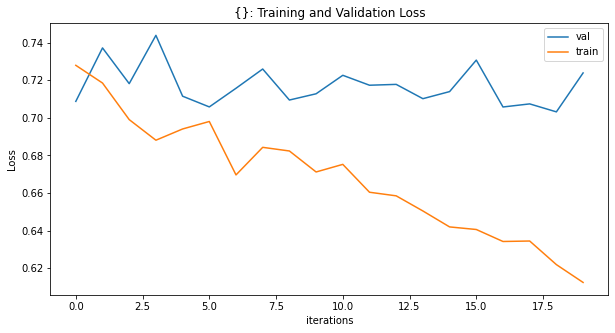

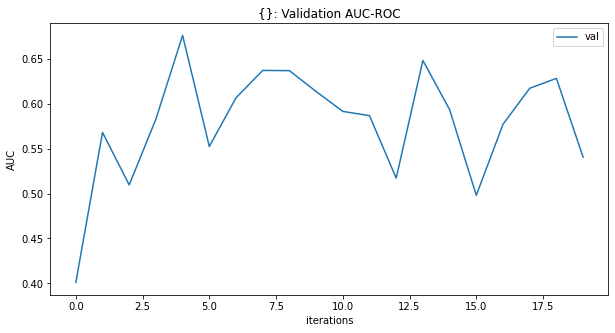

(500, 3) (126, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
314,457,1,T1w
241,349,0,T1w
147,220,1,T1w
389,569,0,T1w
30,48,1,T1w


,BraTS21ID,MGMT_value,MRI_Type
251,367,1,T1w
445,642,0,T1w
410,594,1,T1w
443,640,1,T1w
246,356,0,T1w


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7053, time: 196.00 s
[Epoch Valid: 1] loss: 0.7504, auc: 0.4819, time: 23.00 s
auc improved from 0.0000 to 0.4819. Saved model to 'T1w-e1-loss0.750-auc0.482.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7129, time: 197.00 s
[Epoch Valid: 2] loss: 0.7351, auc: 0.5693, time: 22.00 s
auc improved from 0.4819 to 0.5693. Saved model to 'T1w-e2-loss0.735-auc0.569.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.7046, time: 197.00 s
[Epoch Valid: 3] loss: 0.7245, auc: 0.5673, time: 21.00 s
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.6948, time: 199.00 s
[Epoch Valid: 4] loss: 0.7053, auc: 0.5625, time: 22.00 s
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.7015, time: 198.00 s
[Epoch Valid: 5] loss: 0.7287, auc: 0.4700, time: 22.00 s
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.6999, time: 199.00 s
[Epoch Valid: 6] loss: 0.7341, auc: 0.4604, time: 21.00 s
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.7027, time: 198.00 s
[Epoch Valid: 7] loss: 0.7184, auc: 0.5693, time: 23.00 s
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.7077, time: 198.00 s
[Epoch Valid: 8] loss: 0.7177, auc: 0.4531, time: 22.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.6936, time: 197.00 s
[Epoch Valid: 9] loss: 0.7224, auc: 0.5053, time: 21.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6945, time: 198.00 s
[Epoch Valid: 10] loss: 0.7298, auc: 0.5197, time: 22.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.7019, time: 198.00 s
[Epoch Valid: 11] loss: 0.7272, auc: 0.6190, time: 22.00 s
auc improved from 0.5693 to 0.6190. Saved model to 'T1w-e11-loss0.727-auc0.619.pth'
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6986, time: 198.00 s
[Epoch Valid: 12] loss: 0.7299, auc: 0.5786, time: 23.00 s
EPOCH: 13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 13] loss: 0.6930, time: 197.00 s
[Epoch Valid: 13] loss: 0.7217, auc: 0.5267, time: 21.00 s
EPOCH: 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 14] loss: 0.6978, time: 198.00 s
[Epoch Valid: 14] loss: 0.7224, auc: 0.5769, time: 22.00 s
EPOCH: 15


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 15] loss: 0.6919, time: 198.00 s
[Epoch Valid: 15] loss: 0.7249, auc: 0.5784, time: 22.00 s
EPOCH: 16


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 16] loss: 0.6886, time: 198.00 s
[Epoch Valid: 16] loss: 0.7269, auc: 0.5945, time: 22.00 s
EPOCH: 17


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 17] loss: 0.6831, time: 198.00 s
[Epoch Valid: 17] loss: 0.7239, auc: 0.5852, time: 23.00 s
EPOCH: 18


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 18] loss: 0.6837, time: 198.00 s
[Epoch Valid: 18] loss: 0.7268, auc: 0.6230, time: 22.00 s
auc improved from 0.6190 to 0.6230. Saved model to 'T1w-e18-loss0.727-auc0.623.pth'
EPOCH: 19


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 19] loss: 0.6776, time: 197.00 s
[Epoch Valid: 19] loss: 0.7253, auc: 0.5524, time: 22.00 s
EPOCH: 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 20] loss: 0.6611, time: 198.00 s
[Epoch Valid: 20] loss: 0.7281, auc: 0.5733, time: 21.00 s


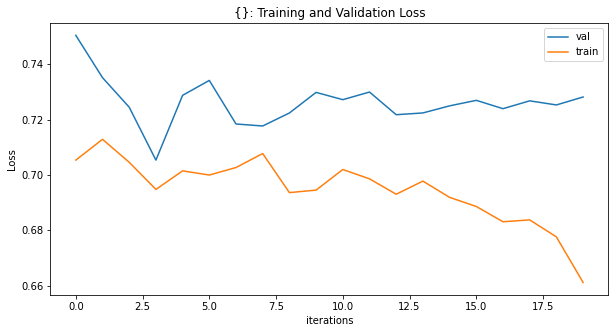

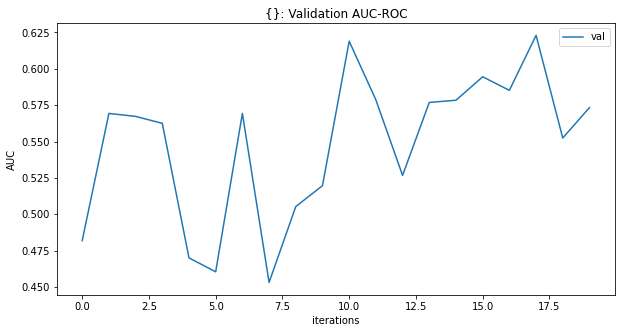

(500, 3) (126, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
314,457,1,T1wCE
241,349,0,T1wCE
147,220,1,T1wCE
389,569,0,T1wCE
30,48,1,T1wCE


,BraTS21ID,MGMT_value,MRI_Type
251,367,1,T1wCE
445,642,0,T1wCE
410,594,1,T1wCE
443,640,1,T1wCE
246,356,0,T1wCE


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7313, time: 196.00 s
[Epoch Valid: 1] loss: 0.7341, auc: 0.4624, time: 23.00 s
auc improved from 0.0000 to 0.4624. Saved model to 'T1wCE-e1-loss0.734-auc0.462.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.6982, time: 198.00 s
[Epoch Valid: 2] loss: 0.7343, auc: 0.4798, time: 23.00 s
auc improved from 0.4624 to 0.4798. Saved model to 'T1wCE-e2-loss0.734-auc0.480.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.6898, time: 198.00 s
[Epoch Valid: 3] loss: 0.7191, auc: 0.4834, time: 22.00 s
auc improved from 0.4798 to 0.4834. Saved model to 'T1wCE-e3-loss0.719-auc0.483.pth'
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.6951, time: 198.00 s
[Epoch Valid: 4] loss: 0.7305, auc: 0.4940, time: 22.00 s
auc improved from 0.4834 to 0.4940. Saved model to 'T1wCE-e4-loss0.730-auc0.494.pth'
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.6928, time: 197.00 s
[Epoch Valid: 5] loss: 0.7230, auc: 0.5484, time: 22.00 s
auc improved from 0.4940 to 0.5484. Saved model to 'T1wCE-e5-loss0.723-auc0.548.pth'
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.7031, time: 198.00 s
[Epoch Valid: 6] loss: 0.7349, auc: 0.5693, time: 21.00 s
auc improved from 0.5484 to 0.5693. Saved model to 'T1wCE-e6-loss0.735-auc0.569.pth'
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.6959, time: 198.00 s
[Epoch Valid: 7] loss: 0.7273, auc: 0.4995, time: 23.00 s
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6907, time: 198.00 s
[Epoch Valid: 8] loss: 0.7262, auc: 0.5867, time: 22.00 s
auc improved from 0.5693 to 0.5867. Saved model to 'T1wCE-e8-loss0.726-auc0.587.pth'
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.6837, time: 198.00 s
[Epoch Valid: 9] loss: 0.7213, auc: 0.5159, time: 22.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6861, time: 199.00 s
[Epoch Valid: 10] loss: 0.7340, auc: 0.4945, time: 23.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6905, time: 199.00 s
[Epoch Valid: 11] loss: 0.7302, auc: 0.5413, time: 22.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6855, time: 199.00 s
[Epoch Valid: 12] loss: 0.7253, auc: 0.5428, time: 22.00 s
EPOCH: 13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 13] loss: 0.6749, time: 199.00 s
[Epoch Valid: 13] loss: 0.7317, auc: 0.5189, time: 24.00 s
EPOCH: 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 14] loss: 0.6738, time: 199.00 s
[Epoch Valid: 14] loss: 0.7309, auc: 0.4574, time: 22.00 s
EPOCH: 15


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 15] loss: 0.6776, time: 199.00 s
[Epoch Valid: 15] loss: 0.7266, auc: 0.5925, time: 22.00 s
auc improved from 0.5867 to 0.5925. Saved model to 'T1wCE-e15-loss0.727-auc0.592.pth'
EPOCH: 16


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 16] loss: 0.6767, time: 201.00 s
[Epoch Valid: 16] loss: 0.7215, auc: 0.6069, time: 24.00 s
auc improved from 0.5925 to 0.6069. Saved model to 'T1wCE-e16-loss0.721-auc0.607.pth'
EPOCH: 17


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 17] loss: 0.6680, time: 198.00 s
[Epoch Valid: 17] loss: 0.7223, auc: 0.6391, time: 22.00 s
auc improved from 0.6069 to 0.6391. Saved model to 'T1wCE-e17-loss0.722-auc0.639.pth'
EPOCH: 18


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 18] loss: 0.6639, time: 199.00 s
[Epoch Valid: 18] loss: 0.7274, auc: 0.6502, time: 22.00 s
auc improved from 0.6391 to 0.6502. Saved model to 'T1wCE-e18-loss0.727-auc0.650.pth'
EPOCH: 19


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 19] loss: 0.6482, time: 200.00 s
[Epoch Valid: 19] loss: 0.7142, auc: 0.6212, time: 24.00 s
EPOCH: 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 20] loss: 0.6529, time: 200.00 s
[Epoch Valid: 20] loss: 0.7215, auc: 0.5998, time: 22.00 s


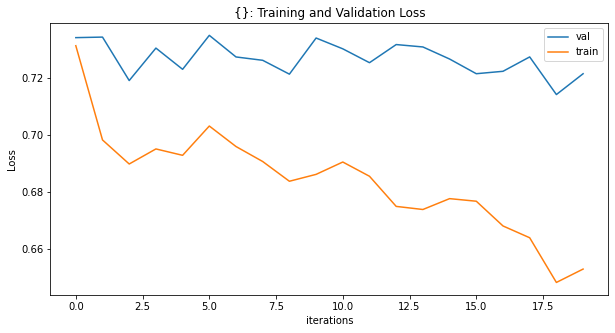

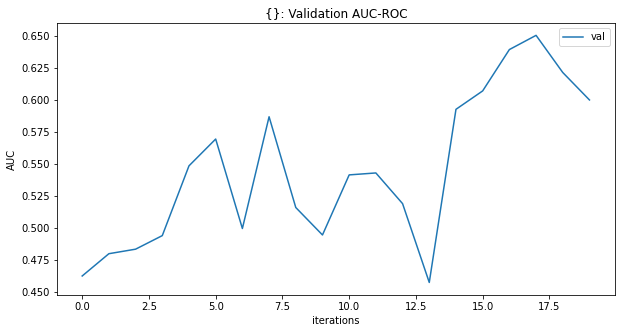

(500, 3) (126, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
314,457,1,T2w
241,349,0,T2w
147,220,1,T2w
389,569,0,T2w
30,48,1,T2w


,BraTS21ID,MGMT_value,MRI_Type
251,367,1,T2w
445,642,0,T2w
410,594,1,T2w
443,640,1,T2w
246,356,0,T2w


EPOCH: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 1] loss: 0.7423, time: 199.00 s
[Epoch Valid: 1] loss: 0.7556, auc: 0.4965, time: 24.00 s
auc improved from 0.0000 to 0.4965. Saved model to 'T2w-e1-loss0.756-auc0.496.pth'
EPOCH: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 2] loss: 0.7104, time: 201.00 s
[Epoch Valid: 2] loss: 0.7214, auc: 0.5721, time: 24.00 s
auc improved from 0.4965 to 0.5721. Saved model to 'T2w-e2-loss0.721-auc0.572.pth'
EPOCH: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 3] loss: 0.7036, time: 199.00 s
[Epoch Valid: 3] loss: 0.7038, auc: 0.6376, time: 21.00 s
auc improved from 0.5721 to 0.6376. Saved model to 'T2w-e3-loss0.704-auc0.638.pth'
EPOCH: 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 4] loss: 0.6982, time: 200.00 s
[Epoch Valid: 4] loss: 0.7108, auc: 0.6242, time: 22.00 s
EPOCH: 5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 5] loss: 0.6988, time: 199.00 s
[Epoch Valid: 5] loss: 0.7190, auc: 0.6220, time: 23.00 s
EPOCH: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 6] loss: 0.6955, time: 197.00 s
[Epoch Valid: 6] loss: 0.7193, auc: 0.6424, time: 21.00 s
auc improved from 0.6376 to 0.6424. Saved model to 'T2w-e6-loss0.719-auc0.642.pth'
EPOCH: 7


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 7] loss: 0.6916, time: 197.00 s
[Epoch Valid: 7] loss: 0.7115, auc: 0.6452, time: 21.00 s
auc improved from 0.6424 to 0.6452. Saved model to 'T2w-e7-loss0.712-auc0.645.pth'
EPOCH: 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 8] loss: 0.6952, time: 199.00 s
[Epoch Valid: 8] loss: 0.7197, auc: 0.5985, time: 23.00 s
EPOCH: 9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 9] loss: 0.6816, time: 198.00 s
[Epoch Valid: 9] loss: 0.7253, auc: 0.5930, time: 22.00 s
EPOCH: 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 10] loss: 0.6836, time: 199.00 s
[Epoch Valid: 10] loss: 0.7200, auc: 0.6026, time: 21.00 s
EPOCH: 11


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 11] loss: 0.6823, time: 198.00 s
[Epoch Valid: 11] loss: 0.7230, auc: 0.5955, time: 22.00 s
EPOCH: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 12] loss: 0.6836, time: 198.00 s
[Epoch Valid: 12] loss: 0.7197, auc: 0.5859, time: 22.00 s
EPOCH: 13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 13] loss: 0.6629, time: 198.00 s
[Epoch Valid: 13] loss: 0.7121, auc: 0.5970, time: 22.00 s
EPOCH: 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 14] loss: 0.6704, time: 199.00 s
[Epoch Valid: 14] loss: 0.7269, auc: 0.5302, time: 23.00 s
EPOCH: 15


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 15] loss: 0.6763, time: 201.00 s
[Epoch Valid: 15] loss: 0.7167, auc: 0.6071, time: 24.00 s
EPOCH: 16


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 16] loss: 0.6718, time: 200.00 s
[Epoch Valid: 16] loss: 0.7100, auc: 0.6424, time: 22.00 s
EPOCH: 17


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 17] loss: 0.6581, time: 198.00 s
[Epoch Valid: 17] loss: 0.7147, auc: 0.6192, time: 22.00 s
EPOCH: 18


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 18] loss: 0.6538, time: 198.00 s
[Epoch Valid: 18] loss: 0.7303, auc: 0.5524, time: 22.00 s
EPOCH: 19


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 19] loss: 0.6475, time: 198.00 s
[Epoch Valid: 19] loss: 0.7235, auc: 0.5489, time: 23.00 s
EPOCH: 20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch Train: 20] loss: 0.6564, time: 198.00 s
[Epoch Valid: 20] loss: 0.7253, auc: 0.5408, time: 22.00 s


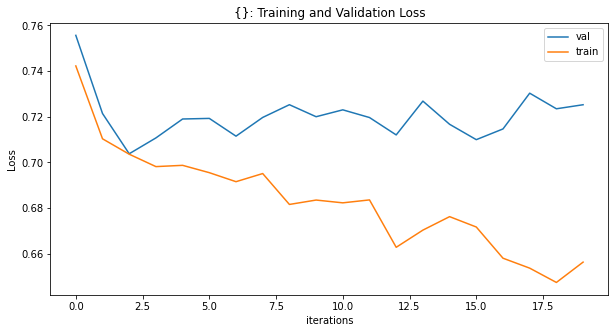

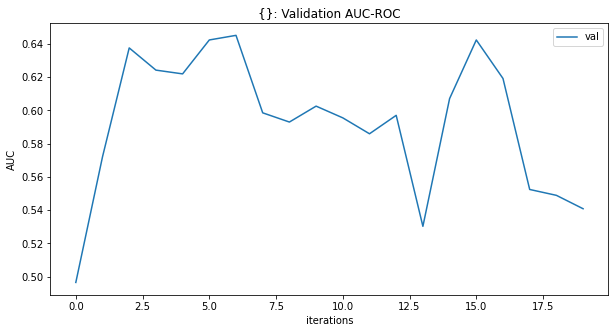

['FLAIR-e5-loss0.712-auc0.676.pth', 'T1w-e18-loss0.727-auc0.623.pth', 'T1wCE-e18-loss0.727-auc0.650.pth', 'T2w-e7-loss0.712-auc0.645.pth']


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    display(df_valid.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=8,
    )

    model = build_model()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        N_EPOCHS, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        N_EPOCHS,
    )
    
    trainer.display_plots(mri_type)
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

# Prediction

In [13]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = build_model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(torch.tensor(batch["X"]).float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

**Validation**

Predict: FLAIR-e5-loss0.712-auc0.676.pth FLAIR (126, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predict: T1w-e18-loss0.727-auc0.623.pth T1w (126, 3)
Predict: T1wCE-e18-loss0.727-auc0.650.pth T1wCE (126, 3)
Predict: T2w-e7-loss0.712-auc0.645.pth T2w (126, 3)
Validation ensemble AUC: 0.7041


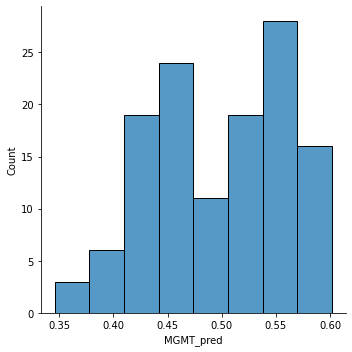

In [14]:
df_pred = df_valid.set_index("BraTS21ID")
df_pred["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_pred, mtype, "train")
    df_pred["MGMT_pred"] += pred["MGMT_value"]
df_pred["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_pred["MGMT_value"], df_pred["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_pred["MGMT_pred"])